In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.5.0


In [2]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
DATA_SIZE = 12000

## Hyper parameters

We have played a little to tweak these values.

In [6]:
num_epochs      = 501
batch_size      = 256

train_size  = int(0.7  * (DATA_SIZE // batch_size))
val_size    = int(0.15  * (DATA_SIZE // batch_size))
test_size   = int(0.15  * (DATA_SIZE // batch_size))

# Adams
learning_rate   = 0.005

## Data

We will get rid of the `userId` column.

In [7]:
column_names = ['userId', 'age', 'gender', 'scentLover', 'ecoInterest', 'MrPropre', 'Antikal', 'Ariel', 'Dash', 'pods', 'powder', 'liquid', 'electricToothbrush', 'likesPets', 'hasPet', 'daysSinceActivity', 'nbChildren', 'magasin', 'moyenneSurface', 'superMarket', 'hyperMarket', 'drive', 'hardDiscount', 'labels']

selected_names = ['age', 'gender', 'scentLover', 'ecoInterest', 'MrPropre', 'Antikal', 'Ariel', 'Dash', 'pods', 'powder', 'liquid', 'electricToothbrush', 'likesPets', 'hasPet', 'daysSinceActivity', 'nbChildren', 'magasin', 'moyenneSurface', 'superMarket', 'hyperMarket', 'drive', 'hardDiscount', 'labels']

label_name = column_names[-1]

Let's load the data from our `csv`.

In [8]:
full_dataset = tf.data.experimental.make_csv_dataset(
    r"/data/train.csv",
    batch_size,
    column_names=column_names,
    select_columns=selected_names,
    label_name=label_name,
    num_epochs=1)


`Tensorflow` needs tensors, so we sill convert every row into a tensor.

In [ ]:
def pack_features_vector(features, labels):
    """Pack the features into a single array."""
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

full_dataset = full_dataset.map(pack_features_vector)

Splitting the data into:
- training
- validation
- testing

This will be usefull later on.

In [ ]:
full_dataset.shuffle(buffer_size=DATA_SIZE)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

## Model

A lot of experementing went in here. In the end we decided to go for 4 layers, `relu` as the main activation function and `sigmoid` at the end to get an answer between 0 and 1. 

Here's a quick reminder of these functions

| Name                          | Mathematical expression           | 🌐        |
| :-:                           | :-:                               | :-:      |
| ReLU (Rectified Linear Unit)  | $x \mapsto \max(x, 0)$            | [link](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))|
| Sigmoid                       | $x \mapsto \dfrac{1}{1 + e^{-x}}$ | [link](https://en.wikipedia.org/wiki/Sigmoid_function)|

In [9]:
model = tf.keras.Sequential([
  layers.Dense(64, activation=tf.nn.relu, input_shape=(22,)),  # input shape required
  layers.Dense(64, activation=tf.nn.relu),
  layers.Dense(64, activation=tf.nn.relu),
  layers.Dense(1, activation=tf.nn.sigmoid)                    # sigmoid so result is in [0, 1]
])

## Train

These callbacks can be a little slow, but allow for us to save more data as well as prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) through the use of [early stopping](https://en.wikipedia.org/wiki/Early_stopping)

In [10]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]


TODO

In [11]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=[
                      tf.keras.losses.BinaryCrossentropy(
                          from_logits=False, name='binary_crossentropy'),
                      'accuracy'])

    # Displays information on our model
    model.summary()

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        callbacks=get_callbacks(name),
        verbose=0,
        workers=4,
        use_multiprocessing=True)
    return history

Let's train a model

In [13]:
histories = {}
histories['NoDropout'] = compile_and_fit(model, 'first model')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1472      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5935,  binary_crossentropy:0.6711,  loss:0.6711,  val_accuracy:0.6131,  val_binary_crossentropy:0.6503,  val_loss:0.6505,  
....................................................................................................
Epoch

Let's plot the evolution of accuracy throughout the epochs and see how our model evolved.

(0.6, 1.0)

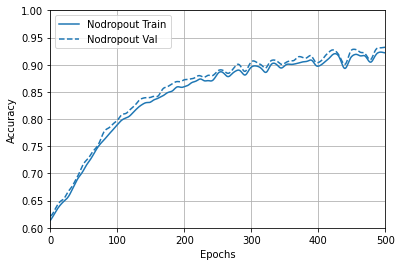

In [14]:
plotter = tfdocs.plots.HistoryPlotter(metric='accuracy', smoothing_std=10)
plotter.plot(histories)
plt.ylim([0.6, 1])

## Testing the model

We will be using the data that was left out at the beginning, data that the model has never seen in order to test it's performance and check for overfitting.

In [15]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

6/6 [==============================] - 1s 10ms/step - loss: 0.1653 - binary_crossentropy: 0.1653 - accuracy: 0.9258


{'loss': 0.1652573049068451,
 'binary_crossentropy': 0.1652573049068451,
 'accuracy': 0.92578125}

## Generating a Submission

We will now be usig the model we just trained to generate a submission for the [kaggle](https://www.kaggle.com/c/st4-data-challenge-2021) competition.

In [16]:
import pandas as pd
df = pd.read_csv(r"/data/test.csv")

def predictRow(row):
    # We do not take the first item as it is the userid
    tensor = tf.convert_to_tensor([[x for x in row[1:]]])
    return 'Auto' if model.predict(tensor) > 0.5 else 'Hand'

submission = pd.DataFrame()

submission["userId"] = df["userId"]
submission["washDishes"] = df.apply(predictRow, axis=1)

submission.to_csv('./data/submission.csv', index=False)